# Simple volume- and surface-based neuroimaging analyses

Roberto Toro, Valparaíso, 2016

We will use open data from the ABIDE initiative (Autism Brain Imaging Data Exchange). We will obtain either static data from Amazon, or interactive data from BrainBox.

Information about the demographic and phenotypic variables available can be found here:

http://fcon_1000.projects.nitrc.org/indi/abide/ABIDEII_Data_Legend.pdf

Information about the neuroimaging data available at Amazon's S3 can be found here:

http://preprocessed-connectomes-project.org/abide/download.html

## 1. Imports

In [359]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [360]:
import urllib2 as url
import re
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.power as smp
import matplotlib.pyplot as plt
from StringIO import StringIO
import json

# Install seaborn typing `conda install seaborn`
import seaborn as sns

# Install nilearn and nibabel typing `pip install nilearn`
import nibabel as nib
import nilearn
from nilearn import plotting

## 2. Regional brain differences between patients with autism and controls (from ABIDE in Amazon)

In [361]:
# Import phenotype file from amazon
pheno_url="https://s3.amazonaws.com/fcp-indi/data/Projects/ABIDE_Initiative/Phenotypic_V1_0b_preprocessed1.csv"
res=url.urlopen(pheno_url)
txt=res.read()
pheno_df=pd.read_csv(StringIO(txt))

# The column FILE_ID contains the code used to index the data at amazon. The 1st row's code is incorrect. Fix it.
pheno_df.loc[0,'FILE_ID']="Pitt_0050002"

# NaN values are indicated as -9999, replace that by a proper NaN value
pheno_df=pheno_df.replace(-9999,np.nan)

# Print data frame
pd.set_option('display.max_columns', None)
pheno_df

,Unnamed: 0,Unnamed: 0.1,SUB_ID,X,subject,SITE_ID,FILE_ID,DX_GROUP,DSM_IV_TR,AGE_AT_SCAN,SEX,HANDEDNESS_CATEGORY,HANDEDNESS_SCORES,FIQ,VIQ,PIQ,FIQ_TEST_TYPE,VIQ_TEST_TYPE,PIQ_TEST_TYPE,ADI_R_SOCIAL_TOTAL_A,ADI_R_VERBAL_TOTAL_BV,ADI_RRB_TOTAL_C,ADI_R_ONSET_TOTAL_D,ADI_R_RSRCH_RELIABLE,ADOS_MODULE,ADOS_TOTAL,ADOS_COMM,ADOS_SOCIAL,ADOS_STEREO_BEHAV,ADOS_RSRCH_RELIABLE,ADOS_GOTHAM_SOCAFFECT,ADOS_GOTHAM_RRB,ADOS_GOTHAM_TOTAL,ADOS_GOTHAM_SEVERITY,SRS_VERSION,SRS_RAW_TOTAL,SRS_AWARENESS,SRS_COGNITION,SRS_COMMUNICATION,SRS_MOTIVATION,SRS_MANNERISMS,SCQ_TOTAL,AQ_TOTAL,COMORBIDITY,CURRENT_MED_STATUS,MEDICATION_NAME,OFF_STIMULANTS_AT_SCAN,VINELAND_RECEPTIVE_V_SCALED,VINELAND_EXPRESSIVE_V_SCALED,VINELAND_WRITTEN_V_SCALED,VINELAND_COMMUNICATION_STANDARD,VINELAND_PERSONAL_V_SCALED,VINELAND_DOMESTIC_V_SCALED,VINELAND_COMMUNITY_V_SCALED,VINELAND_DAILYLVNG_STANDARD,VINELAND_INTERPERSONAL_V_SCALED,VINELAND_PLAY_V_SCALED,VINELAND_COPING_V_SCALED,VINELAND_SOCIAL_STANDARD,VINELAND_SUM_SCORES,VINELAND_ABC_STANDARD,VINELAND_INFORMANT,WISC_IV_VCI,WISC_IV_PRI,WISC_IV_WMI,WISC_IV_PSI,WISC_IV_SIM_SCALED,WISC_IV_VOCAB_SCALED,WISC_IV_INFO_SCALED,WISC_IV_BLK_DSN_SCALED,WISC_IV_PIC_CON_SCALED,WISC_IV_MATRIX_SCALED,WISC_IV_DIGIT_SPAN_SCALED,WISC_IV_LET_NUM_SCALED,WISC_IV_CODING_SCALED,WISC_IV_SYM_SCALED,EYE_STATUS_AT_SCAN,AGE_AT_MPRAGE,BMI,anat_cnr,anat_efc,anat_fber,anat_fwhm,anat_qi1,anat_snr,func_efc,func_fber,func_fwhm,func_dvars,func_outlier,func_quality,func_mean_fd,func_num_fd,func_perc_fd,func_gsr,qc_rater_1,qc_notes_rater_1,qc_anat_rater_2,qc_anat_notes_rater_2,qc_func_rater_2,qc_func_notes_rater_2,qc_anat_rater_3,qc_anat_notes_rater_3,qc_func_rater_3,qc_func_notes_rater_3,SUB_IN_SMP
0,0,1,50002,1,50002,PITT,Pitt_0050002,1,1.0,16.77,1,Ambi,NaN,103.0,116.0,89.0,WASI,WASI,WASI,16.0,9.0,5.0,4.0,1.0,4.0,12.0,4.0,8.0,3.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,10.201539,1.194664,16.223458,3.878000,0.152711,12.072452,0.613128,45.446551,1.873339,1.054931,0.000641,0.011443,0.116828,8.0,3.980100,0.054346,fail,NaN,OK,NaN,fail,ic-parietal-cerebellum,OK,NaN,fail,ERROR #24,1
1,1,2,50003,2,50003,PITT,Pitt_0050003,1,1.0,24.45,1,R,NaN,124.0,128.0,115.0,WASI,WASI,WASI,27.0,22.0,5.0,3.0,1.0,4.0,13.0,5.0,8.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,Fluoxetine,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,7.165701,1.126752,10.460008,4.282238,0.161716,9.241155,0.578301,56.286350,2.012112,0.949857,0.000474,0.031781,0.322092,135.0,67.164179,0.041862,OK,NaN,OK,NaN,OK,NaN,OK,NaN,OK,NaN,1
2,2,3,50004,3,50004,PITT,Pitt_0050004,1,1.0,19.09,1,R,NaN,113.0,108.0,117.0,WASI,WASI,WASI,19.0,12.0,5.0,3.0,1.0,4.0,18.0,6.0,12.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,7.698144,1.226218,9.725750,3.881684,0.174186,9.323463,0.578960,63.317943,1.866104,1.180605,0.008262,0.014260,0.127745,29.0,14.427861,0.046745,OK,NaN,OK,NaN,OK,NaN,OK,NaN,OK,NaN,1
3,3,4,50005,4,50005,PITT,Pitt_0050005,1,1.0,13.73,2,R,NaN,119.0,117.0,118.0,WASI,WASI,WASI,23.0,19.0,3.0,4.0,1.0,4.0,12.0,4.0,8.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,Fluoxetine,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,9.071807,1.256278,11.198226,3.628667,0.119269,10.814200,0.556064,70.800354,1.918278,1.092030,0.001711,0.019205,0.128136,22.0,10.945274,0.027963,OK,NaN,OK,NaN,maybe,ic-parietal-cerebellum,OK,NaN,OK,NaN,0
4,4,5,50006,5,50006,PITT,Pitt_0050006,1,1.0,13.37,1,L,NaN,109.0,99.0,119.0,WASI,WASI,WASI,13.0,10.0,4.0,3.0,1.0,4.0,12.0,4.0,8.0,4.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,N

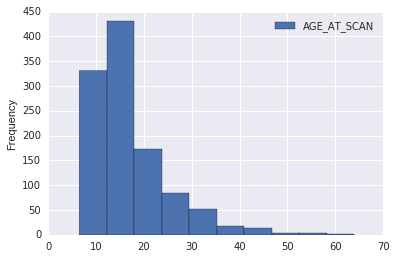

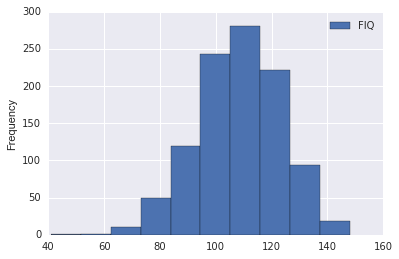

In [362]:
# Plot a few measurements
pheno_df.plot(y='AGE_AT_SCAN',kind='hist')
pheno_df.plot(y='FIQ',kind='hist')

## 3. Basic statistical power computations

In [363]:
# ABIDE 1 included 1102 subjects. Load the first N for testing
N=50

# Statistical power calculations
# (more info at http://jpktd.blogspot.cl/2013/03/statistical-power-in-statsmodels.html)

# Given our sample size N, what is our power to detect small, medium and large effects
d_small = 0.25
d_medium = 0.5
d_large = 1
print "Power for standard effect sizes:"
print smp.TTestIndPower().solve_power(d_small, nobs1=N/2, ratio=1, alpha=0.05, alternative='two-sided')
print smp.TTestIndPower().solve_power(d_medium, nobs1=N/2, ratio=1, alpha=0.05, alternative='two-sided')
print smp.TTestIndPower().solve_power(d_large, nobs1=N/2, ratio=1, alpha=0.05, alternative='two-sided')

# What number of subjects would we need to detect a give effect size with 80% power?
d=0.5
print "Minimum number of subjects per group required to detect an effect size of "+str(d)+" with 80% power:"
print smp.TTestIndPower().solve_power(d, power=0.8, ratio=1, alpha=0.05, alternative='two-sided')

Power for standard effect sizes:
0.139404465581
0.41010033258
0.933707643674
Minimum number of subjects per group required to detect an effect size of 0.5 with 80% power:
63.7656117754


## 4. Load regional brain volume measurements for a subset of individuals 

In [364]:
# Load summary data for measurements of subcortical structures

base_url="https://s3.amazonaws.com/fcp-indi/data/Projects/ABIDE_Initiative/Outputs/freesurfer/5.1/"
filename="/stats/aseg.stats"

sub_df=[];
for i in range(0,N):
    aseg_url=base_url+pheno_df.FILE_ID[i]+filename
    print(str(i)+". "+aseg_url)
    res=url.urlopen(aseg_url)
    txt=res.read()
    txt=txt.split("\n")[68:113];
    txt="\n".join(txt);
    sub_df.append(pd.read_csv(StringIO(txt),sep='\s+',header=None))

0. https://s3.amazonaws.com/fcp-indi/data/Projects/ABIDE_Initiative/Outputs/freesurfer/5.1/Pitt_0050002/stats/aseg.stats
1. https://s3.amazonaws.com/fcp-indi/data/Projects/ABIDE_Initiative/Outputs/freesurfer/5.1/Pitt_0050003/stats/aseg.stats
2. https://s3.amazonaws.com/fcp-indi/data/Projects/ABIDE_Initiative/Outputs/freesurfer/5.1/Pitt_0050004/stats/aseg.stats
3. https://s3.amazonaws.com/fcp-indi/data/Projects/ABIDE_Initiative/Outputs/freesurfer/5.1/Pitt_0050005/stats/aseg.stats
4. https://s3.amazonaws.com/fcp-indi/data/Projects/ABIDE_Initiative/Outputs/freesurfer/5.1/Pitt_0050006/stats/aseg.stats
5. https://s3.amazonaws.com/fcp-indi/data/Projects/ABIDE_Initiative/Outputs/freesurfer/5.1/Pitt_0050007/stats/aseg.stats
6. https://s3.amazonaws.com/fcp-indi/data/Projects/ABIDE_Initiative/Outputs/freesurfer/5.1/Pitt_0050008/stats/aseg.stats
7. https://s3.amazonaws.com/fcp-indi/data/Projects/ABIDE_Initiative/Outputs/freesurfer/5.1/Pitt_0050009/stats/aseg.stats
8. https://s3.amazonaws.com/fcp-

In [365]:
# Print the 1st data frame
sub_df[0]

,0,1,2,3,4,5,6,7,8,9
0,1,4,5669,5669.0,Left-Lateral-Ventricle,20.3089,13.7839,0.0,77.0,77.0
1,2,5,150,150.0,Left-Inf-Lat-Vent,44.9542,9.3298,26.0,70.0,44.0
2,3,7,15349,15349.0,Left-Cerebellum-White-Matter,88.1187,6.6592,36.0,105.0,69.0
3,4,8,60374,60374.0,Left-Cerebellum-Cortex,57.5871,10.1604,15.0,98.0,83.0
4,5,10,7324,7324.0,Left-Thalamus-Proper,88.2386,9.0647,46.0,107.0,61.0
5,6,11,4630,4630.0,Left-Caudate,74.7627,8.6105,38.0,103.0,65.0
6,7,12,7381,7381.0,Left-Putamen,82.0556,5.8165,62.0,104.0,42.0
7,8,13,2341,2341.0,Left-Pallidum,96.3279,3.7901,81.0,112.0,31.0
8,9,14,987,987.0,3rd-Ventricle,26.7386,16.6542,0.0,69.0,69.0
9,10,15,1312,1312.0,4th-Ventricle,17.0044,12.4282,0.0,56.0,56.0


## 5. Statistical analyses

### 5.1 Collect the data of interest

We will do our analyses using as covariates the Age at scan and the Diagnosis group. In the following code we will look at the volume of the Hippocampus (left and right hemispheres added). Looking at the first subject's data frame, we see that Left-Hippocampus is row 11 and Right-Hippocampus is row 26. The column containing the volume (in mm3) is the 5th one.

In [366]:
# We will collect all the information in a new data frame containing all
# the information we need.

# Extract AGE_AT_SCAN from the phenotype data frame pheno_dt
age=pheno_df.AGE_AT_SCAN[0:N]

# Extract the Diagnosis (1=Autism, 2=Control)
group=pheno_df.DX_GROUP[0:N]

# Extract the Right and Left Hippocampus rows from each individual's data frame.
h=np.empty(N)
for i in range(0,N):
    lh=sub_df[i].loc[11,5]
    rh=sub_df[i].loc[26,5]
    h[i]=lh+rh

# Create a data frame for all our statistical tests
test_df=pd.DataFrame({'A':age, 'G':group, 'H':h});

# Display number of patients and controls
print "Patients: "+str((group==1).sum())
print "Controls: "+str((group==2).sum())

Patients: 27
Controls: 23


### 5.2 Volume difference in patients vs controls

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      H   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.055
Date:                Mon, 05 Dec 2016   Prob (F-statistic):              0.310
Time:                        08:10:33   Log-Likelihood:                -134.26
No. Observations:                  50   AIC:                             272.5
Df Residuals:                      48   BIC:                             276.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept    133.1510      1.585     84.003      0.000       129.964   136.338
G             -1.0551      1.027     -1.027      0.310        -3.121     1.011
==============================================================================
Omnibus:                        7.941   Durbin-Watson:                   1.820
Prob(Omnibus):                  0.019   Jarque-Bera (JB):                7.243
Skew:                           0.728   Prob(JB):                       0.0267
Kurtosis:                       4.166   Cond. No.                         6.63
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

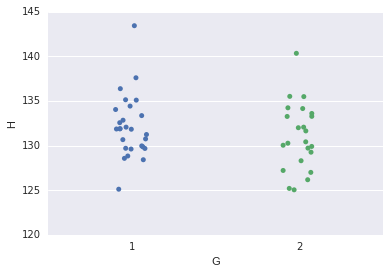

In [367]:
# 1. Difference in Hippocampal volume between patients and controls

# Plot the difference between groups
sns.stripplot(x='G', y='H', data=test_df, jitter=True)

# Statistical test: H is different depending on G
res=smf.ols(formula="H ~ G",data=test_df).fit();
# print(res.f_pvalue);
res.summary()

### 5.3 Change in volume with age

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      H   R-squared:                       0.116
Model:                            OLS   Adj. R-squared:                  0.098
Method:                 Least Squares   F-statistic:                     6.302
Date:                Mon, 05 Dec 2016   Prob (F-statistic):             0.0155
Time:                        08:10:36   Log-Likelihood:                -131.72
No. Observations:                  50   AIC:                             267.4
Df Residuals:                      48   BIC:                             271.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept    128.2646      1.419     90.392      0.000       125.412   131.118
A              0.1742      0.069      2.510      0.015         0.035     0.314
==============================================================================
Omnibus:                        0.423   Durbin-Watson:                   2.317
Prob(Omnibus):                  0.809   Jarque-Bera (JB):                0.046
Skew:                           0.020   Prob(JB):                        0.977
Kurtosis:                       3.144   Cond. No.                         59.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

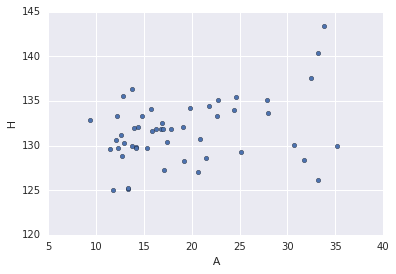

In [368]:
# 1. Change in Hippocampal volume with Age
# (Our null hypothesis is that there is no change)

# Plot a scatter plot with Hippocampal volume vs. Age
test_df.plot(x='A',y='H',kind='scatter')

# Statistical test: H changes with A
res=smf.ols(formula="H ~ A",data=test_df).fit();
# print(res.f_pvalue);
res.summary()

### 5.4 Difference in rate of change in patients vs controls

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      H   R-squared:                       0.146
Model:                            OLS   Adj. R-squared:                  0.091
Method:                 Least Squares   F-statistic:                     2.625
Date:                Mon, 05 Dec 2016   Prob (F-statistic):             0.0616
Time:                        08:10:40   Log-Likelihood:                -130.86
No. Observations:                  50   AIC:                             269.7
Df Residuals:                      46   BIC:                             277.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept     127.8314      1.899     67.331      0.000       124.010   131.653
C(G)[T.2]       1.2049      2.877      0.419      0.677        -4.587     6.997
A               0.2195      0.092      2.398      0.021         0.035     0.404
A:C(G)[T.2]    -0.1136      0.141     -0.804      0.426        -0.398     0.171
==============================================================================
Omnibus:                        0.273   Durbin-Watson:                   2.338
Prob(Omnibus):                  0.873   Jarque-Bera (JB):                0.056
Skew:                           0.081   Prob(JB):                        0.973
Kurtosis:                       3.019   Cond. No.                         150.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

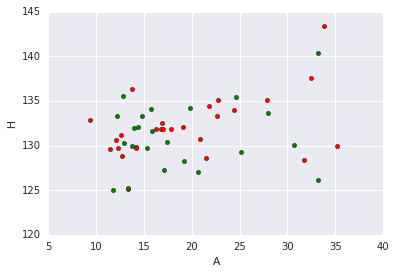

In [369]:
# 2. Difference in the change of the hippocampus between patients and controls
# Our null hypothesis is that there is no difference

# Plot a scatter plot with Hippocampal volume vs. Age
ax = test_df.loc[(test_df.G==1)].plot(x='A',y='H',kind='scatter', color='Red')
test_df.loc[(test_df.G==2)].plot(x='A',y='H',kind='scatter', color='Green', ax=ax)

# Statistical test: H changes with A
res=smf.ols(formula="H ~ A + C(G) + A * C(G)",data=test_df).fit();
# print(res.f_pvalue);
res.summary()

# 6. Brain growth dynamics (from BrainBox)

In [370]:
# Get data from the Ferret Brain Project
prj_url="http://brainbox.pasteur.fr/project/json/abide1"
res=url.urlopen(prj_url)
txt=res.read()
prj=json.loads(txt)

In [371]:
nfiles = len(prj['files']['list'])

In [372]:
# Get individual atlases
isub = 0;
bb_url="http://brainbox.pasteur.fr/mri/json?url="+prj['files']['list'][isub]
res=url.urlopen(bb_url)
txt=res.read()
mri=json.loads(txt)

In [373]:
bb_url

u'http://brainbox.pasteur.fr/mri/json?url=https://s3.amazonaws.com/fcp-indi/data/Projects/ABIDE_Initiative/Outputs/freesurfer/5.1/CMU_a_0050642/mri/T1.mgz'

In [374]:
natlases = len(mri['mri']['atlas'])
base = "http://brainbox.pasteur.fr"+mri['url']
for i in range(0,natlases):
    if 'name' in mri['mri']['atlas'][i] and mri['mri']['atlas'][i]['name'] == 'aseg':
        index = i
        filename = mri['mri']['atlas'][i]['filename']
        print str(index)+". " + base + filename
        break

1. http://brainbox.pasteur.fr/data/0f42c6c924ac7f36dcf8e878e9862272/ulxg15ukveryhkt9.mgz


In [375]:
atlas_url = base + filename
print atlas_url

http://brainbox.pasteur.fr/data/0f42c6c924ac7f36dcf8e878e9862272/ulxg15ukveryhkt9.mgz


In [376]:
f=url.urlopen(atlas_url)
local_file = open(filename, "wb")
local_file.write(f.read())
local_file.close()

In [377]:
img = nib.load(filename)

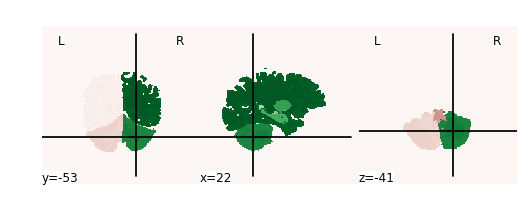

In [378]:
d = plotting.plot_img(img,cmap=plotting.cm.purple_green)

In [379]:
img=nib.load("/Users/roberto/Desktop/BrainBox/public/data/822cf4f30e7a275583dee410fdf523c1/CMU_a_0050646.orig.aseg.mgz")

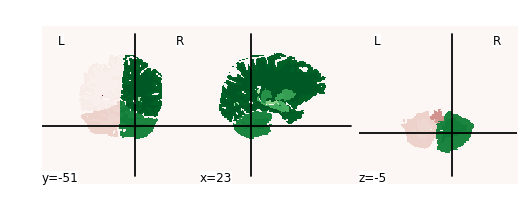

In [380]:
d = plotting.plot_img(img,cmap=plotting.cm.purple_green)